# Самостоятельный проект: "Выбор локации для скважины"


### Содержание:

1. [Цель работы](#target)

2. [Загрузка и подготовка данных](#data_load)

3. [Обучение и проверка модели](#regression)

4. [Подготовка к расчету прибыли](#revenue_calculation)

5. [Расчет прибыли и рисков(Bootstrap)](#bootstrap)


### Цель работы:<a id=target> </a>
Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Возможную прибыль и риски нужно просчитать техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
# основные библиотеки и функции
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

state = np.random.RandomState(12345)

def display_info(data,label):
    print(label)
    display(data.describe())
    print('Первые 5 строк:')
    display(data.head())       
    print('Матрица корреляции:')
    matrix = np.triu(data.corr())
    display(sns.heatmap(data.corr(), annot = True, vmin=-1, vmax=1, fmt='.2g', mask=matrix, cmap='coolwarm'))
    

def linear_regression_train(features_train, target_train, features_test, target_test, label):
    
    Region_Model=LinearRegression()
    
    Region_Model.fit(features_train,target_train)
    
    prediction_train=Region_Model.predict(features_train)
    
    prediction=pd.Series(data=Region_Model.predict(features_test),index=target_test.index)
      
    mse = mean_squared_error(target_test, prediction) 
    mse_train=mean_squared_error(target_train, prediction_train) 
    
    rmse=mse**0.5
    
    rmse_train=mse_train**0.5
    
    pred_mean=prediction.mean()
    
    return pred_mean, rmse_train, rmse , prediction


def draw_hist(forecast,hist_label):   
    fcst=np.array(forecast)/10**9
    mean=fcst.mean()
    plt.hist(fcst,label=hist_label, bins=100, color='grey')
    plt.legend(loc='upper right')   
    plt.grid(True)
    plt.xlabel=('Прибыль, млрд. руб.')
    plt.ylabel=('Число скважин')
    plt.axvline(x=mean, color='black')
    plt.show()
       

def draw_hist_comparision(fact,forecast,hist_label): 
    
    fcst=np.array(forecast)
    fct=np.array(fact)
    plt.hist(fcst, bins=100,alpha=0.5, label='Прогноз')
    plt.xlabel=('Объемы добычи')
    plt.ylabel=('Число скважин')
    plt.hist(fct, bins=100,alpha=0.6, label='Факт')
    plt.legend(loc='upper right')   
    plt.grid(True)
    plt.xlabel=('Объемы добычи')
    plt.ylabel=('Число скважин')
    plt.show()
    
    
          
    
def target_revenue(prediction,target, points_count,bgt,barrel_price):
    
    reg_top=prediction.sort_values(ascending=False)
    reg_top_target=target[reg_top.index][:200]
    volume=reg_top_target.sum()
    revenue_target=(volume*barrel_price*10**3)-bgt  
    
    return revenue_target,volume




    
def bootstrap_by_region(target, prediction,points_count,best_points_count,bgt,barrel_price): 
    
    revenue=[]     
    for i in range(1000):           
        target_subsample = target.sample(n=points_count, random_state=state, replace=True)
        pred_subsample = prediction[target_subsample.index]
        res, vol=target_revenue(pred_subsample,target_subsample,best_points_count,bgt,barrel_price)
        revenue.append(res)                        
    return revenue


def interval(revenue,percentage):
    p=percentage/100
    lower=(1-p)/2
    upper=1-lower
    lower_quantile=np.quantile(revenue,lower)
    upper_quantile=np.quantile(revenue,upper)
    return lower_quantile, upper_quantile




##  Загрузка и подготовка данных<a name=data_load> </a>

Загрузим данные о нефтянных месторождениях в трех регионах.

In [2]:
region_0=pd.read_csv('/datasets/geo_data_0.csv')
region_1=pd.read_csv('/datasets/geo_data_1.csv')
region_2=pd.read_csv('/datasets/geo_data_2.csv')

Выведем информацию о данных:

Регион 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Первые 5 строк:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Матрица корреляции:


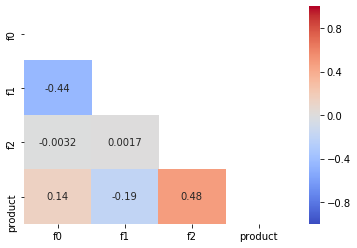

In [3]:
display_info(region_0,'Регион 0')


Регион 1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Первые 5 строк:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Матрица корреляции:


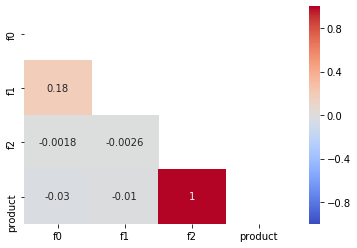

In [4]:
display_info(region_1,'Регион 1')

Регион 2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Первые 5 строк:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Матрица корреляции:


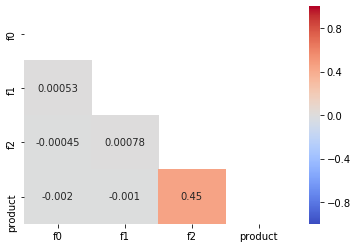

In [5]:
display_info(region_2, 'Регион 2')

В каждой таблице содержится 10000 строк с данными о скважинах:

id — уникальный идентификатор скважины

f0, f1, f2 — три признака точек

product — объём запасов в скважине (тыс. баррелей).


Пропусков в данных нет, есть скважины с 0 запасом. По матрицам корреляции заметно, что сильной зависимости между данными нет, кроме случая в Регионе 1, где коэффициент корреляции между f2 и product составляет 1.

Разделим наши выборки на обучающую и валидационную(75:25). Поле id не является признаком , влияющим на объемы добычи, поэтому его в features не включаем.

In [6]:
# признаки
reg0_features=region_0.drop(['id','product'], axis=1)
reg1_features=region_1.drop(['id','product'], axis=1)
reg2_features=region_2.drop(['id','product'], axis=1)

#целевой признак
reg0_target=region_0['product']
reg1_target=region_1['product']
reg2_target=region_2['product']



Разделим данные на обучающую и тестовые выборки:

In [7]:
reg0_features_train,reg0_features_valid,reg0_target_train,reg0_target_valid=train_test_split(reg0_features, reg0_target, 
                                                                                           test_size=.25,
                                                                                           random_state=54321)

reg1_features_train,reg1_features_valid,reg1_target_train,reg1_target_valid=train_test_split(reg1_features, reg1_target, 
                                                                                           test_size=.25,
                                                                                           random_state=54321)

reg2_features_train,reg2_features_valid,reg2_target_train,reg2_target_valid=train_test_split(reg2_features, reg2_target, 
                                                                                           test_size=.25,
                                                                                           random_state=54321)



### Вывод: 
Нам предоставлены 3 файла с данными о нефтянных местровождениях в 3 разных регионах. Каждый из файлов содержит 10000 строк c id скважины, некими оценками и объемом запасов. Данные для 3х регионов разделены на обучающую и тестовые выборки(в соотношении 75:25).

## Обучение и проверка модели<a id=regression> </a>

Создадим и обучим модель для Региона 0:

In [8]:
prediction_0, rmse_train_0, rmse_0, prediction0= linear_regression_train(reg0_features_train, reg0_target_train, 
                                                        reg0_features_valid, reg0_target_valid, 'Регион 0')
print("Средний запас предсказанного сырья:{:.2f}".format(prediction_0))
print("RMSE на обучающей выборке:{:.2f}".format(rmse_train_0))
print("RMSE на валидационной выборке:{:.2f}".format(rmse_0))


Средний запас предсказанного сырья:92.16
RMSE на обучающей выборке:37.69
RMSE на валидационной выборке:37.68


Построим распределение прогнозных значений и фактических:

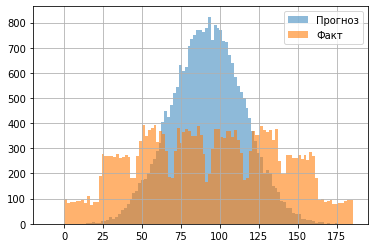

In [9]:
draw_hist_comparision(reg0_target_valid,prediction0,"Регион 0 План/Факт")

У данной модели высокий показатель ошибки, треть от среднего значения.

Создадим и обучим модель для Региона 1:

In [10]:
prediction_1, rmse_train_1, rmse_1, prediction1= linear_regression_train(reg1_features_train, reg1_target_train, 
                                                        reg1_features_valid, reg1_target_valid, 'Регион 0')


print("Средний запас предсказанного сырья:{:.2f}".format(prediction_1))
print("RMSE на обучающей выборке:{:.2f}".format(rmse_train_1))
print("RMSE на валидационной выборке:{:.2f}".format(rmse_1))

Средний запас предсказанного сырья:68.45
RMSE на обучающей выборке:0.89
RMSE на валидационной выборке:0.89


Проверим как распределены прогнозняе и фактические значения:

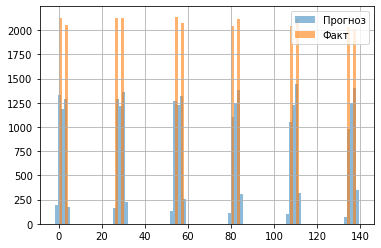

In [11]:
draw_hist_comparision(reg1_target_valid,prediction1,"Регион 1 План/Факт")

Данная модель показала неплохой результат, ошибка меньше тысячи бареллей

Создадим и обучим модель для Региона 2:

In [12]:
prediction_2, rmse_train_2, rmse_2, prediction2= linear_regression_train(reg2_features_train, reg2_target_train, 
                                                        reg2_features_valid, reg2_target_valid, 'Регион 0')

print("Средний запас предсказанного сырья:{:.2f}".format(prediction_2))
print("RMSE на обучающей выборке:{:.2f}".format(rmse_train_2))
print("RMSE на валидационной выборке:{:.2f}".format(rmse_2))

Средний запас предсказанного сырья:94.92
RMSE на обучающей выборке:40.02
RMSE на валидационной выборке:40.15


Построим распределение прогнозных и фактичесикх значений:

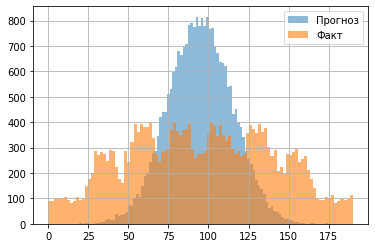

In [13]:
draw_hist_comparision(reg2_target_valid,prediction2,"Регион 1 План/Факт")

У данной модели также слишком высокий показатель среднеквадратичной ошибки, почти половина от среднего запаса по региону.

### Вывод:
На данном этапе были подготовлены 3 модели линейной регрессии для каждого региона. Лучший результат(самая низкая RMSE) показала модель для 1го региона, модели Региона 0 и Региона 1 имеют высокий показатель RMSE( почти половина среднего предсказанного значения). На диаграммах заметно, что теряются потенциально убыточные и потенциально прибыльные скважины.

## Подготовка к расчёту прибыли<a id=revenue_calculation> </a>

По условиям задачи:

•	При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

•	Бюджет на разработку скважин в регионе — 10 млрд рублей.

•	При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.


Создадим переменные с параметрами выше:

In [14]:
FIELDS_TOTAL=500
FIELDS_BEST=200
PRICE_PER_BARREL=450
BUDGET=10**10

Найдем точку безубыточности:

In [15]:
be_point=BUDGET/(FIELDS_BEST*PRICE_PER_BARREL*(10**3))
print("Достаточный объём сырья для безубыточной разработки новой скважины: {:.2f} тыс. баррелей".format(be_point))

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей


Выведем данные о средних предсказанных объемах на скважину по регионам  и сравним с целевым показателем:

In [16]:
print("Регион 0: Средний запас сырья: {:.2f} тыс. баррелей, это {:.0%} от целевого объема".format(prediction_0,prediction_0/be_point))
print("Регион 1: Средний запас сырья: {:.2f} тыс. баррелей, это {:.0%} от целевого объема".format(prediction_1,prediction_1/be_point))
print("Регион 2: Средний запас сырья: {:.2f} тыс. баррелей, это {:.0%} от целевого объема".format(prediction_2,prediction_2/be_point))

Регион 0: Средний запас сырья: 92.16 тыс. баррелей, это 83% от целевого объема
Регион 1: Средний запас сырья: 68.45 тыс. баррелей, это 62% от целевого объема
Регион 2: Средний запас сырья: 94.92 тыс. баррелей, это 85% от целевого объема


Пока средний предсказанный объем по всем регионам ниже, чем точка безубыточности. Посмотрим сколько точек могут дать нужный объем нефти.

In [17]:
region0_potential=np.sum(prediction0>=be_point)
region1_potential=np.sum(prediction1>=be_point)
region2_potential=np.sum(prediction2>=be_point)
print('Число потенциально выгодных скважин по регионам:')
print("Регион 0: {} скважин с объемом не менее {:.0f} тыс. бареллей".format(region0_potential,be_point))
print("Регион 1: {} скважин с объемом не менее {:.0f} тыс. бареллей".format(region1_potential,be_point))
print("Регион 2: {} скважин с объемом не менее {:.0f} тыс. бареллей".format(region2_potential,be_point))

Число потенциально выгодных скважин по регионам:
Регион 0: 5222 скважин с объемом не менее 111 тыс. бареллей
Регион 1: 4457 скважин с объемом не менее 111 тыс. бареллей
Регион 2: 5237 скважин с объемом не менее 111 тыс. бареллей


Выберем в каждом регионе по 200 месторождений с максимальными значениями предсказанных объемов запасов и вычислим для них целевую валовую прибыль:

In [18]:
region0_revenue_target,volume0=target_revenue(prediction0,reg0_target_valid,FIELDS_BEST,BUDGET,PRICE_PER_BARREL)
region1_revenue_target,volume1=target_revenue(prediction1,reg1_target_valid,FIELDS_BEST,BUDGET,PRICE_PER_BARREL)
region2_revenue_target,volume2=target_revenue(prediction2,reg2_target_valid,FIELDS_BEST,BUDGET,PRICE_PER_BARREL)


Найдем валовую прибыль для полученного объема сырья:

In [19]:
print('Ожидаемая прибыль по лучшим скважинам:')
print("Регион 0 ТОП 200: Прибыль: {:.2f} млрд. руб., объем {:.0f} тыс. баррелей".format(region0_revenue_target/10**9,volume0))
print("Регион 1 ТОП 200: Прибыль: {:.2f} млрд. руб., объем {:.0f} тыс. баррелей".format(region1_revenue_target/10**9,volume1))
print("Регион 2 ТОП 200: Прибыль: {:.2f} млрд. руб., объем {:.0f} тыс. баррелей".format(region2_revenue_target/10**9,volume2))

Ожидаемая прибыль по лучшим скважинам:
Регион 0 ТОП 200: Прибыль: 3.18 млрд. руб., объем 29286 тыс. баррелей
Регион 1 ТОП 200: Прибыль: 2.42 млрд. руб., объем 27589 тыс. баррелей
Регион 2 ТОП 200: Прибыль: 2.41 млрд. руб., объем 27586 тыс. баррелей


### Вывод: 
На данном этапе были созданы модели для расчета объемов добычи по каждому региону. Модели для Региона 0 и Региона 2 показали высокие значения среднеквадратичной ошибки, треть и почти половина от среднего предсказанного значения и такие ошибки могут дорого стоить при разработке нового месторождения. точка безубыточности при текущих затратах составляет 111 тысяч баррелей, это выше ччем средние значения по всем регионам. Однако, в каждом регионе есть не менее 5000 скважин, которые удовлетворяют данному требованию, выбрать из них 200 мест для разработки труда не составит. Целевая прибыль для трех регионов лежит в диапазоне от 2,4 до 3,1 млрд рублей при суммарной добыче 27-29 тыс. баррелей.

## Расчёт прибыли и рисков <a id=bootstrap> </a>

Найдем распределение прибыли по каждому региону

In [20]:
reg0=bootstrap_by_region(reg0_target_valid, prediction0,FIELDS_TOTAL,FIELDS_BEST,BUDGET,PRICE_PER_BARREL)
reg1=bootstrap_by_region(reg1_target_valid, prediction1,FIELDS_TOTAL,FIELDS_BEST,BUDGET,PRICE_PER_BARREL)
reg2=bootstrap_by_region(reg2_target_valid, prediction2,FIELDS_TOTAL,FIELDS_BEST,BUDGET,PRICE_PER_BARREL)


Время от времени длина целевого массива больше, чем длина предсказаний. В массиве предсказаний могут появится дубли, после этого из массива taget подтягиваются все подходящие значения(т.к. непонятно, как их сопоставлять). Изменим алгоритм в функции, чтобы топ200 отбирался не по массиву предсказаний, а по массиву target(что и было указано в условии задачи)

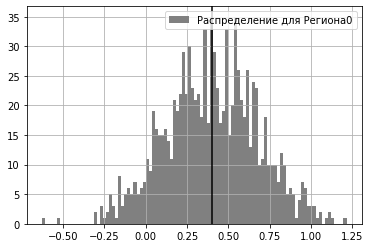

In [22]:
draw_hist(reg0,"Распределение для Региона0")

In [23]:
print('Среднее значение прибыли:{:.3f} млрд. руб.'.format(mean(reg0)/10**9))

Среднее значение прибыли:0.399 млрд. руб.


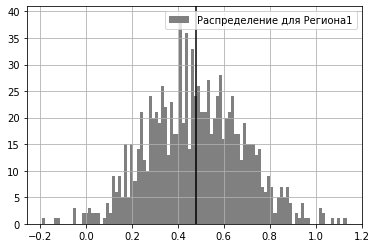

In [24]:
draw_hist(reg1,"Распределение для Региона1")

In [25]:
print('Среднее значение прибыли:{:.3f} млрд. руб.'.format(mean(reg1)/10**9))

Среднее значение прибыли:0.478 млрд. руб.


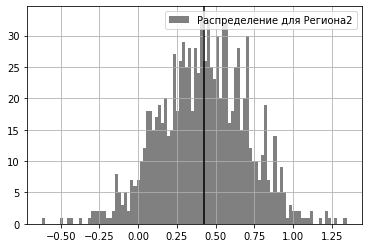

In [26]:
draw_hist(reg2,"Распределение для Региона2")

In [27]:
print('Среднее значение прибыли:{:.3f} млрд. руб.'.format(mean(reg2)/10**9))

Среднее значение прибыли:0.423 млрд. руб.


Найдем 95% доверительный интевал по каждому региону:

In [28]:
reg0_l, reg0_u=interval(reg0, 95)
print('95% доверительный интервал прибыль Регион0: {:.3f} - {:.3f} млрд. руб.'.format(reg0_l/10**9,reg0_u/10**9))

print('Риск убытков:{:.0%}'.format(np.sum(np.array(reg0)<0)/len(np.array(reg0))))

95% доверительный интервал прибыль Регион0: -0.150 - 0.949 млрд. руб.
Риск убытков:7%


In [29]:
reg1_l, reg1_u=interval(reg1, 95)
print('95% доверительный интервал прибыль Регион1: {:.3f} - {:.3f} млрд. руб.'.format(reg1_l/10**9,reg1_u/10**9))
print('Риск убытков:{:.0%}'.format(np.sum(np.array(reg1)<0)/len(np.array(reg1))))

95% доверительный интервал прибыль Регион1: 0.109 - 0.876 млрд. руб.
Риск убытков:1%


In [30]:
reg2_l, reg2_u=interval(reg2, 95)
print('95% доверительный интервал прибыль Регион2: {:.3f} - {:.3f} млрд. руб.'.format(reg2_l/10**9,reg2_u/10**9))
print('Риск убытков:{:.0%}'.format(np.sum(np.array(reg2)<0)/len(np.array(reg2))))

95% доверительный интервал прибыль Регион2: -0.131 - 0.934 млрд. руб.
Риск убытков:6%


### Вывод: 

После исправления ошибки в функции прибыли получились следующие результаты:
- Регион 0 и Регион 2 имеют риск убытков 7% и 6% соответсвтенно, что не подходит по условиям задачи.
-У Региона 1 риск убытков 1%, что соответвует условиям задачи и границы доверительного интервала положительные, т.е. в 95% случаев компания не понесет убытки при новой разработке. Пока Регион 1 является единственным подходящим для дальнейшей разработки.